# Two task network 

## Network has some inputs

1. The fixation. 
1. The first context mod. 
1. The second ontext mod. 

## Network has five outputs
1. The fixation. 
1. The first output.
1. The second output




<div>
<img src="./images/Sheme.png" width="300"/>
</div>

> Learning rule: superspike

> Neuron type: LifAdex + refrac

> Task: romo


In [6]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt  # for analys
from cgtasknet.net.lifadexrefrac import SNNlifadexrefrac
from cgtasknet.tasks.reduce import RomoTask, RomoTaskParameters
from norse.torch.functional.lif_adex_refrac import LIFAdExRefracParameters
from norse.torch.functional.lif_adex import LIFAdExParameters

# from norse.torch import LIF

## Step -1: Create dataset

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

Device: gpu (cuda)


Task params:


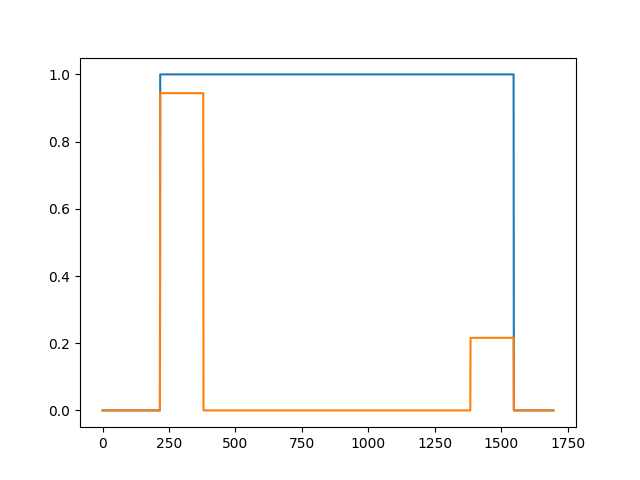

In [8]:
%matplotlib widget
batch_size = 50
number_of_tasks = 1
task_parameters = RomoTaskParameters(
    delay=0.1,
    positive_shift_delay_time=1.0,
    trial_time=0.1,
    positive_shift_trial_time=0.2,
)
# task_parameters = RomoTaskParameters(delay=0.1, positive_shift_delay_time=.0, trial_time = 0.2, positive_shift_trial_time=.0)
Task = RomoTask(
    params=task_parameters,
    batch_size=batch_size,
    uniq_batch=False,
    enable_fixation_delay=False,
)
Task_test = RomoTask(params=task_parameters, batch_size=1)
print("Task params:")

demonstrate_in, demonstrate_out = Task.dataset(1, delay_between=0)
plt.figure()
plt.plot(demonstrate_in[:, 0, 0])
plt.plot(demonstrate_in[:, 0, 1])

plt.show()

## Step 1.1: Create model

In [9]:
feature_size, output_size = Task.feature_and_act_size
hidden_size = 400

neuron_parameters = LIFAdExRefracParameters(
    LIFAdExParameters(v_th=torch.as_tensor(0.65), tau_ada_inv=torch.as_tensor(1)),
    rho_reset=torch.as_tensor(0.1),
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadexrefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
).to(device)
# model = torch.nn.DataParallel(model, device_ids=[0]).to(device)

## Step 1.2: Save pre-learning weights

In [10]:
weights_pre_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        print(f"name = {name}")
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())

name = adexrefrac.input_weights
name = adexrefrac.recurrent_weights
name = exp_f.linear.weight
name = exp_f.linear.bias


## Step 2: loss and creterion 

In [11]:
learning_rate = 1e-3


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
name = f"Train_only_romo_task_reduce_lif_adex_random_delay_long_a{hidden_size}"

#Precreate data

In [13]:
l_inputs = []
l_outputs = []
from tqdm import tqdm

for i in tqdm(range(1000)):
    tmp_inputs, tmp_target_outputs = Task.dataset(number_of_tasks, delay_between=0)
    tmp_inputs += np.random.normal(0, 0.01, size=tmp_inputs.shape)
    l_inputs.append(tmp_inputs)
    l_outputs.append(tmp_target_outputs)

100%|██████████| 1000/1000 [00:09<00:00, 105.80it/s]


## Step 3: Train loop

In [14]:
from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.instruments.instrument_accuracy_network import correct_answer

init_state = LIFAdExRefracInitState(batch_size, hidden_size, device=device)

#

running_loss = 0
from tqdm import tqdm

for i in tqdm(range(1000)):
    inputs = torch.from_numpy(l_inputs[i]).type(torch.float).to(device)
    target_outputs = torch.from_numpy(l_outputs[i]).type(torch.float).to(device)
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, _ = model(inputs)

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        with open("log.txt", "a") as f:
            f.write("epoch: {:d} loss: {:0.5f}\n".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            torch.save(
                model.state_dict(),
                name,
            )
    if i % 20 == 19:
        Task_test = RomoTask(
            params=task_parameters,
            batch_size=batch_size,
            uniq_batch=False,
            enable_fixation_delay=False,
        )
        result = 0
        for j in range(10):
            inputs, target_outputs = Task_test.dataset(1, delay_between=0)
            inputs += np.random.normal(0, 0.01, size=(inputs.shape))
            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs = model(inputs)[0]
            answers = correct_answer(
                outputs[:, :, 1:], target_outputs[:, :, 1:], target_outputs[:, :, 0]
            )
            result += torch.sum(answers).item()
        accuracy = result / batch_size / 10 * 100
        with open("accuracy.txt", "a") as f:
            f.write(f"ecpoch = {i}; correct/all = {accuracy}\n")
print("Finished Training")

  5%|▍         | 46/1000 [05:27<1:53:10,  7.12s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm

task_parameters_test = RomoTaskParameters(
    delay=0.1,
    positive_shift_delay_time=0.2,
    trial_time=0.1,
    positive_shift_trial_time=0.2,
)
Task_test = RomoTask(params=task_parameters_test, batch_size=batch_size)
result = 0
for i in tqdm(range(10)):
    inputs, target_outputs = Task_test.dataset(1, delay_between=0)
    inputs += np.random.normal(0, 0.01, size=inputs.shape)
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    outputs = model(inputs)[0]
    answers = correct_answer(
        outputs[:, :, 1:], target_outputs[:, :, 1:], target_outputs[:, :, 0]
    )
    result += torch.sum(answers).item()
result / batch_size / 10 * 100

In [ ]:
plt.figure()
plt.plot(outputs[:, 0, 1].detach().cpu())
plt.plot(outputs[:, 0, 2].detach().cpu())
plt.show()
plt.figure()
# plt.plot(inputs[:, 0, 0].detach().cpu())
plt.plot(inputs[:, 0, 1].detach().cpu())

In [ ]:
torch.save(model.state_dict(), name)

In [ ]:
if False:
    model.load_state_dict(torch.load("Only_dm_lif_net"))

In [ ]:
dmparamsv = dmparams1
Taskplot = RomoTask(params=dmparamsv, batch_size=1, delay_beetween=100)
inputs, target_outputs = Taskplot.dataset(10)
inputs += np.random.normal(0, 0.01, size=(inputs.shape))
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
outputs, states = model(inputs)

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.legend()
    plt.show()
    plt.close()
for i in range(outputs.shape[2]):
    plt.plot(outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.plot(
        target_outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u^{{target}}_{i + 1}$"
    )
    plt.legend()
    plt.show()
    plt.close()

plt.plot(
    outputs[:, 0, -2].detach().cpu().numpy() - outputs[:, 0, -1].detach().cpu().numpy(),
    label=fr"$u_2 - u_3$",
)
plt.plot(target_outputs[:, 0, -2].detach().cpu().numpy(), label=fr"$u^{{target}}_{2}$")
plt.plot(target_outputs[:, 0, -1].detach().cpu().numpy(), label=fr"$u^{{target}}_{3}$")
plt.legend()
plt.show()
plt.close()

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")

plt.legend()
plt.show()
plt.close()
plt.plot(target_outputs[:, 0, 1].detach().cpu().numpy(), label=fr"$y_{2}$")
plt.plot(target_outputs[:, 0, 2].detach().cpu().numpy(), label=fr"$y_{3}$")

In [ ]:
weights_post_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_post_l.append((param).cpu().numpy())

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow((weights_pre_l[i]), aspect="auto", cmap="jet")
    plt.colorbar()
    plt.show()

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow(
        (weights_post_l[i]),
        aspect="auto",
        cmap="jet",
    )
    plt.colorbar()
    plt.show()

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow(
        (weights_post_l[i] - weights_pre_l[i]),
        aspect="auto",
        cmap="jet",
        vmin=-0.2,
        vmax=0.4,
    )
    plt.colorbar()
    plt.show()